In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
sys.path.append("FixedStrides")
from main import *
results_wolant = pd.read_csv('ip32_wolant_results.csv', sep=';')
results_fst = pd.read_csv('ip32_fst_results.csv', sep=';')
results_equal_dist = pd.read_csv('ip32_equal_dist_results.csv', sep=';')
# results_au = pd.read_csv('ipResults_home_gtx980_australia.csv', sep=';')
# results_au_32bit = pd.read_csv('ip_32bit_au.csv', sep=';')
# results_tokyo = pd.read_csv('ip_32bit_tokyo.csv', sep=';')
# results_au_32bit.drop(results_au_32bit.columns[len(results_au_32bit.columns)-1], axis=1, inplace=True)  # delete NaN column
# results_tokyo.drop(results_tokyo.columns[len(results_tokyo.columns)-1], axis=1, inplace=True)  # delete NaN column

In [2]:
def plot_prefix_distribution(prefixes):
    lengths = utils.get_lengths(prefixes)
    plt.bar(range(1, len(lengths) + 1), lengths, align='center')
    plt.xlabel('Prefix length in bits')
    plt.ylabel('Num occurrences')
    plt.title('Prefix length distribution')
    plt.show()

In [3]:
# prefixes_au = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_australia_012016.txt')
prefixes_tokyo = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_tokyo_012016.txt')
node_counts_tokyo = utils.get_node_counts(prefixes_tokyo)

Read 576846 prefixes from file in 8.125498056411743 seconds


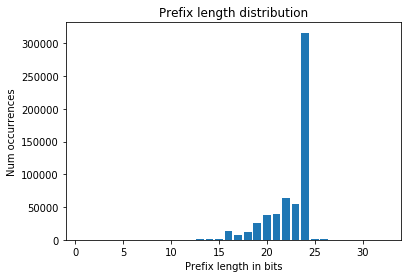

In [4]:
# plot_prefix_distribution(prefixes_au)
plot_prefix_distribution(prefixes_tokyo)

In [5]:
def get_empty_node_stats(tree_levels, strides):
    # Calculate number of empty child pointers in all nodes at each level
    # For example, if we have 100 nodes in level 1 (second level)
    # And the config for root node is 8, then it means the root node has 2^8 - 100 empty/null child pointers
    # TODO move this to utils.get_stats()
    num_empty_pointers_per_lvl = []
    percentage_empty_pointers_per_lvl = []
    total_num_pointers = 0
    for i in range(len(tree_levels) - 1):
        total_num_pointers_in_curr_lvl = tree_levels[i] * (2 ** strides[i])
        num_empty_pointers_in_curr_lvl = total_num_pointers_in_curr_lvl - tree_levels[i + 1]
        total_num_pointers += total_num_pointers_in_curr_lvl
        num_empty_pointers_per_lvl.append(num_empty_pointers_in_curr_lvl)
        percentage_empty_pointers_per_lvl.append(float(round(100 * num_empty_pointers_in_curr_lvl / total_num_pointers_in_curr_lvl, 2)))
    total_empty_pointer_percentage = float(round(100 * sum(num_empty_pointers_per_lvl) / total_num_pointers, 2))
    return num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage
        


def append_stats(row: pd.Series, nodes: list):
    strides = row['Config'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    strides = [int(x) for x in strides]
    tree_levels = row['TreeLevels'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    tree_levels = [int(x) for x in tree_levels]
    num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage = get_empty_node_stats(tree_levels, strides)
    num_empty_pointers_per_lvl = str(num_empty_pointers_per_lvl)
    percentage_empty_pointers_per_lvl = str(percentage_empty_pointers_per_lvl)
    tmp, strides_nodes, cost, percent = utils.get_stats(nodes, strides, ignore_last_level=True)
    build_and_find = float(row['Build']) + float(row['Find'])
    build_and_match = float(row['Build']) + float(row['Match'])
    match_and_find = float(row['Match']) + float(row['Find'])
    return pd.Series([cost, percent, build_and_find, build_and_match, match_and_find, num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage])

def append_stats_to_df(df: pd.DataFrame):
    newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels', 'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage']
    # For now assume Tokyo dataset
    newcols = df.apply(lambda row: append_stats(row, node_counts_tokyo), axis=1)
    newcols.columns = newcol_names
    return df.join(newcols)

In [6]:
results_wolant = append_stats_to_df(results_wolant)
results_fst = append_stats_to_df(results_fst)
results_equal_dist = append_stats_to_df(results_equal_dist)

In [7]:
# results_wolant = results_wolant.sort_values('RandomMatch')
# results_wolant[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_fst = results_fst.sort_values('RandomMatch')
# results_fst[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_equal_dist = results_equal_dist.sort_values('Match')
# results_equal_dist[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

In [26]:
results_wolant = results_wolant.sort_values('MaxItemsPerLevel')
results_wolant[['Config', 'TreeMemoryUniqueOnly', 'MaxItemsPerLevel', 'PercentEmptyPointerLevels', 'RandomMatch', 'Match', 'Find', 'ItemsPerLevel', 'Build', 'EmptyPointerLevels']]

,Config,TreeMemoryUniqueOnly,MaxItemsPerLevel,PercentEmptyPointerLevels,RandomMatch,Match,Find,ItemsPerLevel,Build,EmptyPointerLevels
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3551560,316089,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",0.788544,2.069440,8.60262,"{0, 0, 0, 0, 0, 0, 0, 16, 13, 36, 100, 265, 50...",81.7632,"[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
7,"{8, 4, 4, 2, 2, 2, 2, 8}",2944456,371291,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 97.76]",0.681664,1.159200,27.94750,"{16, 414, 16266, 20015, 63408, 103872, 371291,...",25.7148,"[215, 490, 1711, 1849, 2646, 2918, 68017]"
11,"{8, 2, 2, 2, 2, 2, 2, 2, 2, 8}",2946048,371291,"[83.98, 57.32, 40.71, 38.7, 41.95, 48.92, 34.2...",0.605280,1.193700,26.66400,"{16, 49, 365, 1522, 14744, 20015, 63408, 10387...",36.3263,"[215, 94, 114, 257, 683, 1849, 2646, 2918, 68017]"
6,"{8, 8, 4, 2, 2, 8}",2970800,371291,"[83.98, 91.0, 66.42, 14.37, 97.76]",8.341500,0.995936,34.77490,"{16, 16680, 83423, 103872, 371291, 1564, }",22.9640,"[215, 9551, 10042, 2918, 68017]"
3,"{8, 8, 2, 2, 2, 2, 8}",2971824,371291,"[83.98, 91.0, 48.92, 34.26, 14.37, 97.76]",8.456000,1.036160,26.66190,"{16, 16680, 20015, 63408, 103872, 371291, 1564, }",24.3714,"[215, 9551, 1849, 2646, 2918, 68017]"
2,"{8, 4, 4, 4, 4, 8}",2769680,475163,"[83.98, 74.7, 64.42, 66.42, 98.08]",0.733536,1.687010,36.58870,"{16, 414, 16266, 83423, 475163, 1564, }",22.6215,"[215, 490, 1711, 10042, 79689]"
5,"{8, 8, 4, 4, 8}",2797048,475163,"[83.98, 91.0, 66.42, 98.08]",8.314980,1.550500,35.41400,"{16, 16680, 83423, 475163, 1564, }",19.1387,"[215, 9551, 10042, 79689]"
10,"{4, 5, 4, 5, 6, 4, 2, 2}",2972080,538571,"[12.5, 88.39, 68.75, 76.79, 98.74, 99.82, 88.59]",1.028100,3.749570,38.37330,"{0, 29, 907, 35775, 538571, 1518, 25, 21, }",27.8286,"[2, 396, 572, 6389, 122025, 24898, 163]"
9,"{4, 4, 4, 4, 8, 8}",3311312,558586,"[12.5, 81.7, 74.7, 64.42, 99.36]",2.492610,11.113500,60.63440,"{0, 16, 414, 16266, 558586, 1564, }",22.8818,"[2, 183, 490, 1711, 240361]"
1,"{8, 8, 8, 8}",3338592,558586,"[83.98, 91.0, 99.36]",9.956900,11.093200,60.34080,"{16, 16680, 558586, 1564, }",20.4145,"[215, 9551, 240361]"


In [25]:
results_fst = results_fst.sort_values('MaxItemsPerLevel')
results_fst[['Config', 'TreeMemoryUniqueOnly', 'RandomMatch', 'Match', 'Find', 'ItemsPerLevel', 'MaxItemsPerLevel', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,TreeMemoryUniqueOnly,RandomMatch,Match,Find,ItemsPerLevel,MaxItemsPerLevel,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
10,"{8, 4, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",3379696,0.737312,1.109120,26.81750,"{16, 414, 16266, 20015, 63408, 103872, 55202, ...",316089,90.136753,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",35.7171,"{1,41,166,945,1931,5078,17394,33779,1559,442,6...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
11,"{8, 4, 4, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3}",3383536,0.715680,1.128610,26.88220,"{16, 414, 16266, 20015, 63408, 103872, 55202, ...",316089,90.109119,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",37.8176,"{1,41,166,945,1931,5078,17394,33779,1559,1017,...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
9,"{12, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",3392064,1.812420,1.108640,26.88080,"{430, 16266, 20015, 63408, 103872, 55202, 3160...",316089,90.168056,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",36.8837,"{1,166,945,1931,5078,17394,33779,1559,442,63,30,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
8,"{12, 4, 2, 2, 2, 1, 1, 2, 2, 4}",3394176,1.803230,1.084670,26.55230,"{430, 16266, 20015, 63408, 103872, 55202, 3160...",316089,90.201315,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",30.8613,"{1,166,945,1931,5078,17394,33779,1559,442,46,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
7,"{12, 4, 2, 2, 2, 1, 1, 3, 5}",3408608,1.876420,1.011780,26.86590,"{430, 16266, 20015, 63408, 103872, 55202, 3160...",316089,90.352937,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",31.4056,"{1,166,945,1931,5078,17394,33779,1559,63,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 12..."
6,"{13, 4, 3, 2, 1, 1, 3, 5}",3415496,2.819010,0.942112,31.45560,"{936, 23171, 76012, 103872, 55202, 316089, 150...",316089,91.418692,"[96.83, 68.27, 51.91, 14.37, 2.9, 97.69, 99.49]",27.4011,"{1,260,1320,5078,17394,33779,1559,63,}","[7932, 2840, 5482, 2918, 1009, 65999, 12409]"
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3551560,0.777184,2.824130,8.57805,"{0, 0, 0, 0, 0, 0, 0, 16, 13, 36, 100, 265, 50...",316089,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",85.4229,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
4,"{17, 3, 2, 1, 1, 8}",3837824,45.814400,0.861216,35.47250,"{24107, 76012, 103872, 55202, 316089, 1564, }",316089,93.501291,"[98.99, 51.91, 14.37, 2.9, 97.69]",23.1034,"{1,1320,5078,17394,33779,1559,}","[129752, 5482, 2918, 1009, 65999]"
5,"{17, 3, 2, 1, 1, 3, 5}",3888256,46.306700,0.874912,35.77480,"{24107, 76012, 103872, 55202, 316089, 1501, 63, }",316089,93.986481,"[98.99, 51.91, 14.37, 2.9, 97.69, 99.49]",24.9575,"{1,1320,5078,17394,33779,1559,63,}","[129752, 5482, 2918, 1009, 65999, 12409]"
3,"{18, 3, 2, 1, 8}",4206824,69.273300,0.829888,45.16650,"{36711, 103489, 118993, 316089, 1564, }",316089,99.444746,"[99.26, 40.53, 8.08, 97.69]",20.7005,"{1,1931,9187,33779,1559,}","[260213, 6261, 2969, 65999]"


In [24]:
results_equal_dist = results_equal_dist.sort_values('RandomMatch')
results_equal_dist[['Config', 'RandomMatch', 'Match', 'Find', 'ItemsPerLevel', 'MaxItemsPerLevel', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,Find,ItemsPerLevel,MaxItemsPerLevel,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
4,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.794848,2.984960,8.67203,"{0, 0, 0, 0, 0, 0, 0, 16, 13, 36, 100, 265, 50...",316089,3551560,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",79.0481,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
3,"{20, 1, 1, 1, 1, 8}",195.732000,0.900160,180.73400,"{100119, 40081, 63791, 55202, 316089, 1564, }",316089,7561408,136.816479,"[99.52, 9.54, 5.33, 2.9, 97.69]",21.6736,"{1,5078,9187,17394,33779,1559,}","[1043498, 969, 980, 1009, 65999]"
2,"{20, 2, 1, 1, 8}",196.212000,0.805952,180.20000,"{100119, 103872, 55202, 316089, 1564, }",316089,7455000,132.745921,"[99.52, 14.37, 2.9, 97.69]",20.4013,"{1,5078,17394,33779,1559,}","[1043498, 2918, 1009, 65999]"
1,"{21, 2, 1, 8}",286.005000,0.747456,321.90800,"{140200, 118993, 316089, 1564, }",316089,11469576,185.513142,"[99.56, 8.08, 97.69]",18.8426,"{1,9187,33779,1559,}","[2087965, 2969, 65999]"
0,"{22, 1, 9}",428.793000,29.657400,699.42600,"{203991, 55202, 317653, }",317653,19633256,275.912299,"[99.59, 2.9]",18.3254,"{1,17394,33779,}","[4176910, 1009]"


In [11]:
results_equal_dist.columns
# newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind']
# newcols_au = results_au_32bit.apply(lambda row: append_stats(row, nodes_au), axis=1)
# newcols_tokyo = results_tokyo.apply(lambda row: append_stats(row, nodes_tokyo), axis=1)
# newcols_au.columns = newcol_names
# newcols_tokyo.columns = newcol_names
# results_au_32bit = results_au_32bit.join(newcols_au)
# results_tokyo = results_tokyo.join(newcols_tokyo)
# results_au_32bit = results_au_32bit.sort_values('MatchAndFind')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_tokyo = results_tokyo.sort_values('TreeMemoryUniqueOnly')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_au_32bit = results_au_32bit.sort_values('TreeMemoryUniqueOnly')
# results_au_32bit[['Config', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'TreeLevels', 'ChildrenMemory', 'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_tokyo = results_tokyo.sort_values('Match')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit = results_tokyo.sort_values('Find')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Match'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Find'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Build'])
# results_tokyo['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['Match'].corr(results_au_32bit['Cost'])
# results_tokyo['Match'].corr(results_au_32bit['Cost'])

Index(['deviceId', 'deviceName', 'Dictionary', 'Load', 'Count', 'Sort',
       'Config', 'Reshape', 'Build', 'TreeMemory', 'TreeLevels', 'Depth',
       'TreeMemoryUniqueOnly', 'ChildrenMemory', 'ChildrenCountsMemory',
       'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory',
       'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory',
       'ContainerStartsMemory', 'ContainerLengthsMemory',
       'AverageNodeSizesLevels', 'AverageNodeSize', 'TreeHeight',
       'NodeSizeToHeightRatio', 'ItemsPerLevel', 'MaxItemsPerLevel', 'Find',
       'Match', 'RandomCount', 'RandomMatch', 'RandomSort',
       'RandomSortedMatch', 'HitRate', 'Unnamed: 37', 'Cost', 'Percent',
       'BuildAndFind', 'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels',
       'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage'],
      dtype='object')